#Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import os

#Cloning the github repo

In [2]:
# !rm -rf ml_lab
!git clone https://github.com/SaikotCSE/ml_lab.git

Cloning into 'ml_lab'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 154 (delta 19), reused 64 (delta 6), pack-reused 60 (from 1)
Receiving objects: 100% (154/154), 157.34 MiB | 34.04 MiB/s, done.
Resolving deltas: 100% (24/24), done.


#Data Preprocessing function (Lazy preprocessing)

In [3]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    )
])

#Loading CIFAR-10 Dataset

In [4]:
train_data = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_data = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:01<00:00, 103MB/s]


#CNN Model Architecture

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

#Training Loop (WITH VALIDATION)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(10):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    model.eval()
    correct, total, vloss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            vloss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss.append(vloss / len(test_loader))
    val_acc.append(correct / total)

    print(f"Epoch {epoch+1}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")

Epoch 1: Train Acc=0.5436, Val Acc=0.6102
Epoch 2: Train Acc=0.6796, Val Acc=0.6846
Epoch 3: Train Acc=0.7350, Val Acc=0.7137
Epoch 4: Train Acc=0.7769, Val Acc=0.7068
Epoch 5: Train Acc=0.8094, Val Acc=0.7299
Epoch 6: Train Acc=0.8439, Val Acc=0.7242
Epoch 7: Train Acc=0.8734, Val Acc=0.7276
Epoch 8: Train Acc=0.9013, Val Acc=0.7186
Epoch 9: Train Acc=0.9272, Val Acc=0.7112
Epoch 10: Train Acc=0.9385, Val Acc=0.7065


#Save Model

In [31]:
torch.save(model.state_dict(), "ml_lab/cnn-cifar10-assignment/model/210109.pth")

Only run this cell if you want the model to be downloaded on your local machine

In [32]:
from google.colab import files

files.download("ml_lab/cnn-cifar10-assignment/model/210109.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Traning History

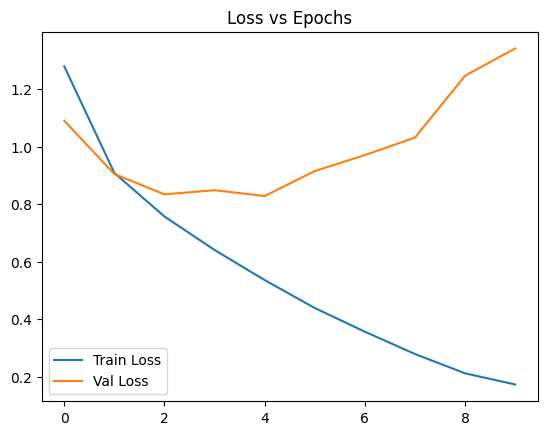

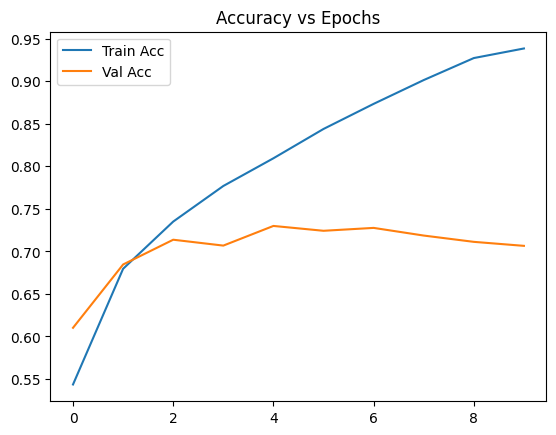

In [33]:
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()

#Confusion Matrix

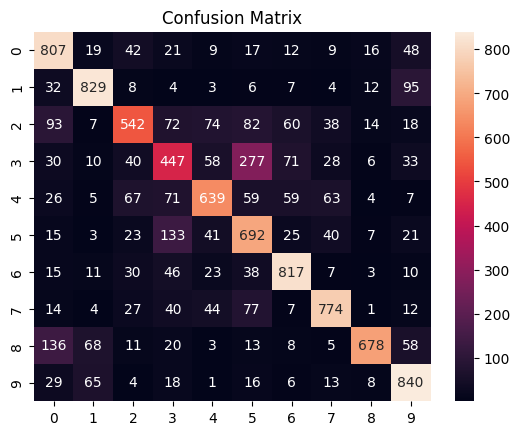

In [34]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

#Visual Error Analysis

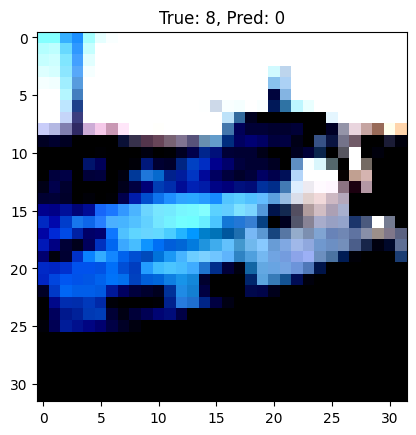

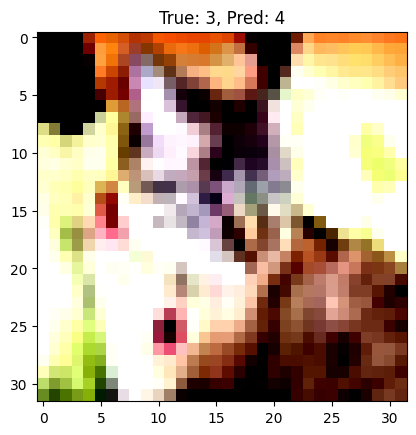

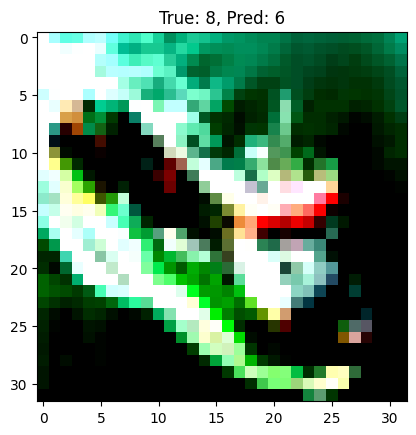

In [35]:
wrong = [(img, y, p) for img, y, p in zip(test_data, y_true, y_pred) if y != p]
samples = wrong[:3]

for img, true, pred in samples:
    plt.imshow(np.transpose(img[0].numpy(), (1,2,0)))
    plt.title(f"True: {true}, Pred: {pred}")
    plt.show()

#Custom Phone Image Prediction

Step 1: Transforming phone image to look like the Cifer dataset **image**

In [40]:
from torchvision import transforms
from PIL import ImageFilter

class CIFARDegrade:
    def __call__(self, img):
        return img.filter(ImageFilter.GaussianBlur(radius=0.8))

phone_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.05
    ),
    CIFARDegrade(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    )
])

Step 2: Predicting with those images

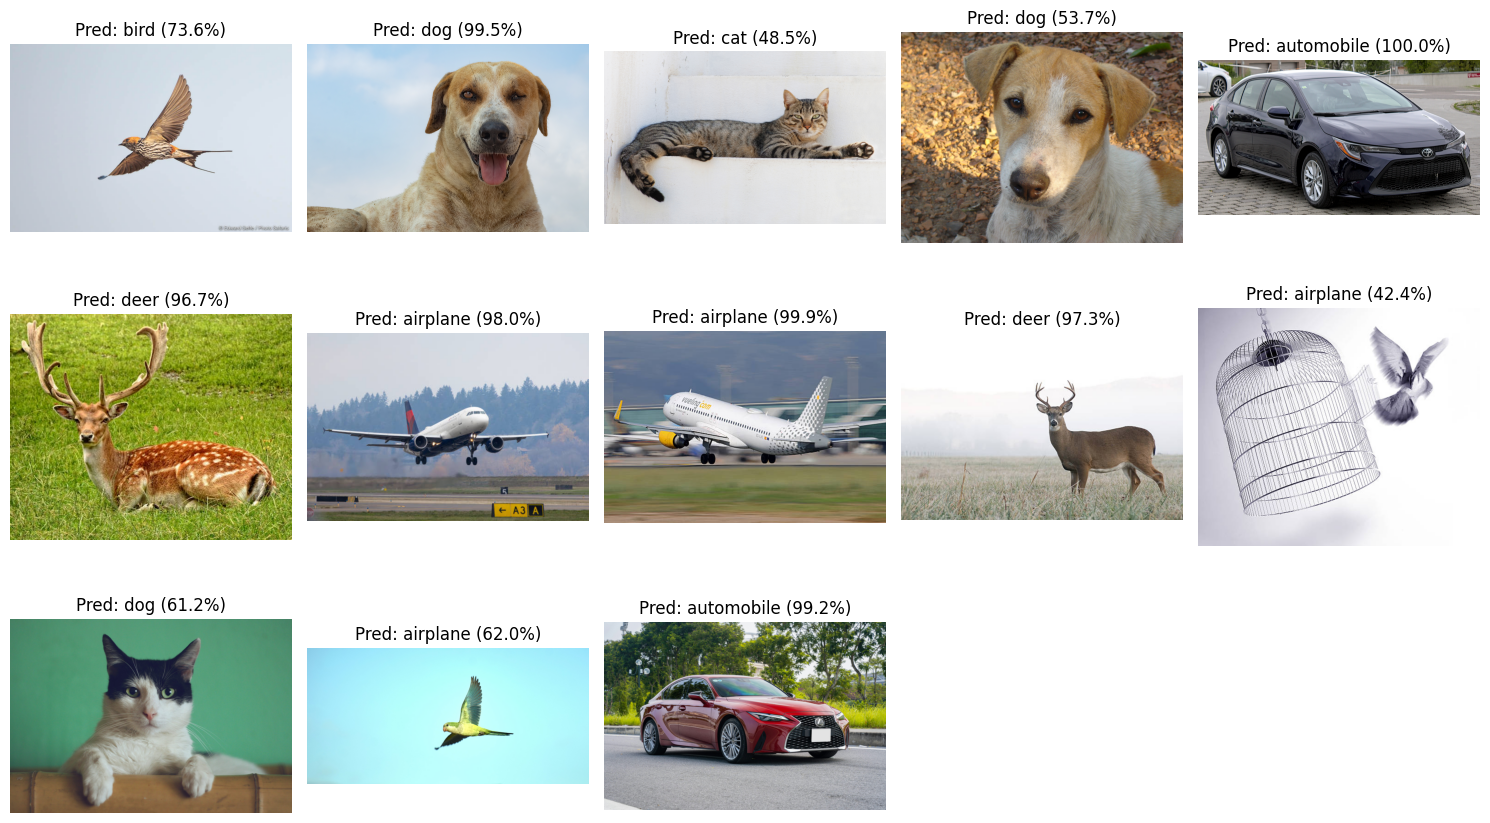

In [41]:
classes = train_data.classes
phone_dir = "ml_lab/cnn-cifar10-assignment/dataset/phone_images"

model.eval()
plt.figure(figsize=(15, 9))

for i, img_name in enumerate(sorted(os.listdir(phone_dir))):
    if i >= 13:
        break
    if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue

    img = Image.open(os.path.join(phone_dir, img_name)).convert('RGB')
    img_t = phone_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        prob = torch.softmax(output, dim=1)
        conf, pred = torch.max(prob, 1)

    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {classes[pred.item()]} ({conf.item()*100:.1f}%)")
    plt.axis('off')

plt.tight_layout()
plt.show()
